# Predicting Pathogen from RNAseq data

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from math import pow
from sklearn.feature_selection import RFECV, RFE
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.svm import LinearSVC, LinearSVR

In [2]:
patient_groups=["control", "viral", "bacterial", "fungal"]
group_id = lambda name: patient_groups.index(name)

df = pd.DataFrame.from_csv("combineSV_WTcpmtable_v2+LeptoCase.txt", sep="\s+").T
num_genes = df.shape[1]
df['coverage'] = df.astype(bool).sum(axis=1)/num_genes*100
df['diagnosis'] = [group_id("bacterial")] * 30 \
    + [group_id("viral")] * 42 \
    + [group_id("control")] * 61

drop_diagnosis = lambda df: df.drop("diagnosis", axis=1)    

lepto_index = "Lepto_Case"
X_test = drop_diagnosis(df[df.index == lepto_index])
y_test = [group_id("bacterial")]

df.drop(lepto_index, inplace=True)
X_train = drop_diagnosis(df)
y_train = df['diagnosis']

print "Training set has %d samples. Testing set has %d samples." % (len(X_train), len(X_test))

Training set has 132 samples. Testing set has 1 samples.


In [3]:
def print_gridsearch_results(clf):
    print("Best: %f using %s" % (clf.best_score_, clf.best_params_))
    means = clf.cv_results_['mean_test_score']
    stds = clf.cv_results_['std_test_score']
    params = clf.cv_results_['params']
    for mean, stdev, param in zip(means, stds, params):
        print("%f (%f) with: %r" % (mean, stdev, param))

In [4]:
from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import LogisticRegression

#parameters={'estimator__C': [pow(2, i) for i in xrange(-25, 4, 1)]}
est = LogisticRegression(class_weight="balanced", C=pow(2, -23))
#est = LinearSVR(C=pow(2, -23))
#clf = RFE(estimator=lr, step=0.01, n_features_to_select=1, verbose=1)
clf = RFECV(cv=4, estimator=est, n_jobs=6, scoring='neg_mean_squared_error', step=.001, verbose=0)
#clf = GridSearchCV(rfe, parameters, scoring='accuracy', n_jobs=8, cv=3, verbose=1)
clf.fit(X_train, y_train)
#print_gridsearch_results(clf)

RFECV(cv=4,
   estimator=LogisticRegression(C=1.19209289551e-07, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False),
   n_jobs=6, scoring='neg_mean_squared_error', step=0.001, verbose=0)

In [5]:
from IPython.core.display import display, HTML

rfe_features = []
for (rank, name) in zip(clf.ranking_, X_test.columns):
    if rank == 1:
        rfe_features.append(name)

s="""
<h2>List of %d genes found by RFE</h2>
<p>Note: the NCBI link will open the target in a new window or tab.</p>
<table>
""" % (clf.n_features_)

ncbi_url = lambda gene: "https://www.ncbi.nlm.nih.gov/gene/?term=%s[Gene Name] AND Human[Organism]" % (gene)

s += "<tr>"
for (i, gene) in enumerate(rfe_features):
    if not i % 10:
        s += "</tr><tr>"
    s += """
    <td><a target=\"_blank\" href=\"%s\">%s</a></td>
    """ %(ncbi_url(gene), gene)
s += "</tr></table>"

display(HTML(s))


A1CF,A2M,A2ML1,AAAS,AADACL3,AAK1,AAMP,AARS,AASDH,AASS
AATF,ABAT,ABCA1,ABCA10,ABCA12,ABCA13,ABCA2,ABCA3,ABCA4,ABCA5
ABCA7,ABCA8,ABCA9,ABCB1,ABCB4,ABCB7,ABCB8,ABCC1,ABCC12,ABCC2
ABCC3,ABCC4,ABCC8,ABCC9,ABCD1,ABCD3,ABCD4,ABCE1,ABCF1,ABCF3
ABHD12,ABHD14B,ABHD17B,ABHD2,ABHD4,ABHD5,ABHD6,ABI1,ABI2,ABI3
ABI3BP,ABL2,ABLIM1,ABLIM3,ABO,ABR,ABTB1,ABTB2,ACACA,ACACB
ACAD8,ACADSB,ACAN,ACAP2,ACAP3,ACAT1,ACAT2,ACBD5,ACBD7,ACE
ACE2,ACER2,ACER3,ACIN1,ACO1,ACO2,ACOT12,ACOT8,ACOX1,ACP1
ACPP,ACRBP,ACSBG2,ACSL1,ACSL3,ACSL4,ACSL5,ACSM2A,ACSM3,ACSM4
ACSM6,ACTA2,ACTB,ACTC1,ACTG1,ACTN2,ACTN3,ACTN4,ACTR2,ACTR3
ACVR1B,ACVR1C,ACVR2A,ACVR2B,ACVRL1,ADAD1,ADAL,ADAM10,ADAM12,ADAM15


Optimal number of features : 8935
Recursive Feature Elimination (RFE) eliminated 14789 features


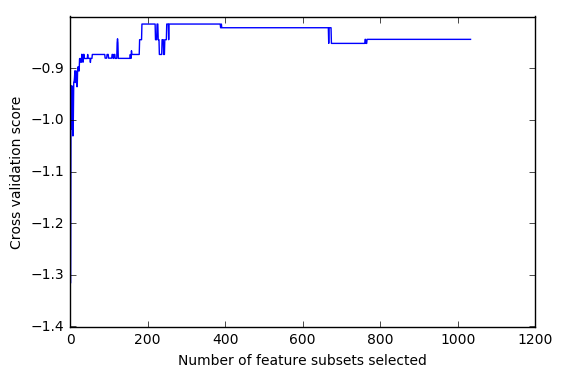

In [6]:
best_estimator = clf

print("Optimal number of features : %d" % best_estimator.n_features_)
print("Recursive Feature Elimination (RFE) eliminated %d features" % (X_train.shape[1] - best_estimator.n_features_))

# Plot number of features VS. cross-validation scores
plt.figure()
plt.xlabel("Number of feature subsets selected")
plt.ylabel("Cross validation score")
plt.plot(range(1, len(best_estimator.grid_scores_) + 1), best_estimator.grid_scores_)
plt.show()

None


ValueError: The least populated class in y has only 1 member, which is too few. The minimum number of groups for any class cannot be less than 2.

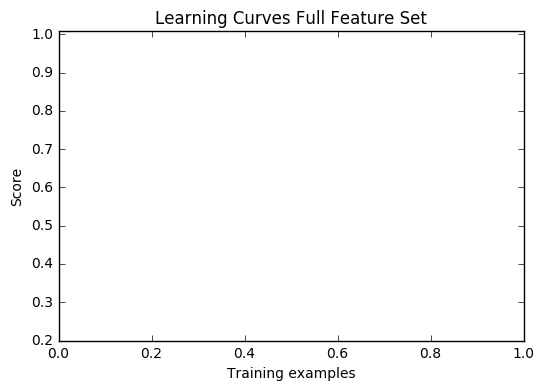

In [7]:
%matplotlib inline
from learning_curves import plot_learning_curve
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedShuffleSplit

def create_learning_curve(title, model):
    cv = StratifiedShuffleSplit(n_splits=2, test_size=0.3, random_state=7)                                     
    plot_learning_curve(model, title, X_test, y_test, (0.2, 1.01), cv=cv, n_jobs=1)
    
create_learning_curve("Learning Curves Full Feature Set", est)
create_learning_curve("Learning Curves RFE Feature Set", clf.estimator_)

plt.show()

## Make predictions based on the model

In [ ]:
from classification_metrics import classification_metrics

est.fit(X_train, y_train)
est_predicted = est.predict(X_test)
print "Full Metrics"
classification_metrics(y_test, est_predicted, patient_groups)
rfe_predicted = clf.predict(X_test)
print "-" * 80
print "\nRFE Metrics"
classification_metrics(y_test, rfe_predicted, patient_groups)

## Review model predictions

In [ ]:
probs = pd.DataFrame(clf.predict_proba(X_test))
probstrs = lambda vals: ["%.2f" % (p*100) for p in vals]

d = {"Predicted": [patient_groups[i] for i in rfe_predicted],
     "Actual": [patient_groups[i] for i in y_test],
     "Prob. control": probstrs(probs[0]),
     "Prob. viral": probstrs(probs[1]),
     "Prob. bacteria": probstrs(probs[2])}

patient_df = pd.DataFrame(d, index=X_test.index)
patient_df.sort_values(by="Actual")

## Review patients the model misclassified

In [ ]:
patient_df[patient_df["Predicted"] != patient_df["Actual"]]